# Team 35 - Forecasting Volatility 

#### Some EDA on Tech Stocks for forecasting stock volatility. 

***

### Some Background on Volatility 

**Volatility** (denoted usually by $\sigma$) is a measure of the variation of an asset over time. 

If the asset is an individual stock, then we can interpret the volatility $\sigma$ as a measure of spread on the fluctuations of the stock price around it's mean. As an application, the volatility is an input into the Black-Scholes formula for computing the fair price of put and call options on the stock. In this context, the volatility is assumed to be constant. 

If the asset is a portfolio of stocks, then we can interpret the volatility in terms of what is known as the portfolio's **beta**, which measures how the price fluctuations of the portfolio correlate with the price fluctuations of a larger market (often taken to be something like the S&P 500 index). 

Since most financial instruments trade at varying scales, we consider the **returns** (defined below) of the asset and measure the volatility of the returns instead, this allows us to compare volatilties in a meaningful sense. 

#### Types of Volatility 

Assume that a stock follows a price process: 

$$ 
\text{d} \log(S_{t}) = \mu_i \text{d}t + \sigma_{t} \text{d}W_t
$$
where $\mu_i$ is the drift of the stock, $\sigma_{t}$ is the volatility at time $t$ and $W_t$ denotes the standard Brownian motion. Then the stochastic process $\{S_t\}$ is a time series. In particular, we are assuming that the volatility $\sigma_t$ is a stochastic process. 

##### Actual Volatility

We can estimate the volatility $\sigma_t$ of a stock by taking 
$$
\sigma_t \approx \mathbf{V}_t =  \text{square of the log returns }.
$$

where $m$ is a period window (1-day, 10-days, 30-days, etc). Estimating $\sigma_t$ this way is known as estimating the **actual volatility**. 

##### Realized Volatility

Another way to model the volatility of the stock is to estimate the **integrated variance**: 
$$
IV_t = \int_0^t \sigma_s^2 ds.
$$
We can estimate $IV_t$ using the **realised variance**, which requires some extra info. 

We define the **log (daily) returns** of $S_t$ to be: 

$$ 
r_t = \log(S_t) - \log(S_{t-1}). 
$$

In this way $\mathbf{R}_t = \{r_t\}$ becomes a time series. We can estimate the $IV_t$ of $S_t$ by considering the **Realized Variance** on the intraday squared returns: 

$$
RV_t = \sum_{i = 1}^m (r_i)^2
$$
where $m$ is the number of intraday returns on day $t$. It can be shown that as $m \to \infty$, $RV_t \to IV_t$. We then call $\sqrt{RV_t}$ the **realized volatility**. 

#### Volatility Forecasting 

Let $\mathbf{R}_t$ and $\mathbf{V}_t$ denote the time series of log returns and actual volatility respectively. To forecast volatility, we assume there is a function: 

$$ 
\sigma_{t+1}^2 \approx V_{t+1} = f(\mathbf{R}_t,\mathbf{V}_t )
$$

and we look to model $f$ using various machine learning techniques. 

For the purpose of this project, we will model the **actual volatility**. 

***

## Packages

In [77]:
## for data collection
import yfinance as yf

## for data handling and computations
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import set_style
## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")

***
## Dataset

For this initial exploration, we will look a the tech stocks alone. 

In [78]:
# Define the ticker symbols
tech_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
# biotech_tickers = ['JNJ', 'LLY', 'NVO', 'MRK', 'RHHBY']
# industrial_tickers = ['DOW', 'GE', 'F', 'UNP', 'SO']
# healthcare_tickers = ['PFE', 'ABBV', 'CVS', 'AMGN', 'UNH']
# crypto_tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD']


# Get the daily closing prices for the tech data for the last 5 years
tech_data = yf.download(tech_tickers, period='2y')['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [79]:
tech_data.head(5)

,AAPL,AMZN,GOOGL,MSFT,NVDA
Date,,,,,
2021-05-26,125.380722,163.257996,119.015503,247.064896,156.743912
2021-05-27,123.828903,161.505493,118.134003,244.923248,154.627396
2021-05-28,123.166664,161.153503,117.842499,245.286743,162.180069
2021-06-01,122.840477,160.932495,119.058998,243.046875,162.379715
2021-06-02,123.611450,161.699493,118.529503,242.948624,167.508804


The next code chunk would compute the realized volatility of each stock, by pulling the intraday prices and then estimating $RV_t$. IT CAN BE IGNORED.

In [80]:
# from datetime import timedelta

# for col in tech_data:    
#     for date in tech_data.index:
#         start_date = str(date.date())
#         end_date = str(date.date() + timedelta(days=1))
#         intra_month = yf.download(col, start=start_date, end=end_date, interval='1h')['Adj Close']
#         realized_vol = np.sqrt(np.sum(np.square(np.log(intra_month) - np.log(intra_month.shift(-1)) )))
#         tech_data.loc[date, f'{col}_RV'] = realized_vol

# tech_data.head(5)

***
## Preprocessing

We preprocess `tech_data` so that it has the `log_returns` for each of the component's stocks. We are going to forecast volatility by assuming it is the variance (or standard deviation) of the log returns process.

In [107]:
for col in tech_tickers:
    tech_data[f'{col}_log_returns'] = np.log(tech_data[col]) - np.log(tech_data[col].shift(-1))
    tech_data[f'{col}_Vol'] = tech_data[f'{col}_log_returns'].rolling(30).std()

In [108]:
tech_data.tail(5)

,AAPL,AMZN,GOOGL,MSFT,NVDA,AAPL_log_returns,AAPL_Vol,MSFT_log_returns,MSFT_Vol,GOOGL_log_returns,GOOGL_Vol,AMZN_log_returns,AMZN_Vol,NVDA_log_returns,NVDA_Vol
Date,,,,,,,,,,,,,,,
2023-05-18,175.050003,118.150002,122.830002,318.519989,316.779999,-0.000628,0.013428,0.000565,0.017534,0.000570,0.017743,0.016212,0.022103,0.013155,0.021717
2023-05-19,175.160004,116.250000,122.760002,318.339996,312.640015,0.005496,0.013067,-0.008882,0.017448,-0.018482,0.017401,0.010724,0.022267,0.002819,0.021571
2023-05-22,174.199997,115.010002,125.050003,321.179993,311.760010,0.015271,0.013342,0.018604,0.017238,0.020113,0.017793,0.000174,0.021729,0.015777,0.021595
2023-05-23,171.559998,114.989998,122.559998,315.260010,306.880005,-0.001631,0.013285,0.004483,0.017302,0.013637,0.017994,-0.015190,0.021247,0.004900,0.020959
2023-05-24,171.839996,116.750000,120.900002,313.850006,305.380005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
## remove rows with None values
tech_data.dropna(inplace=True)

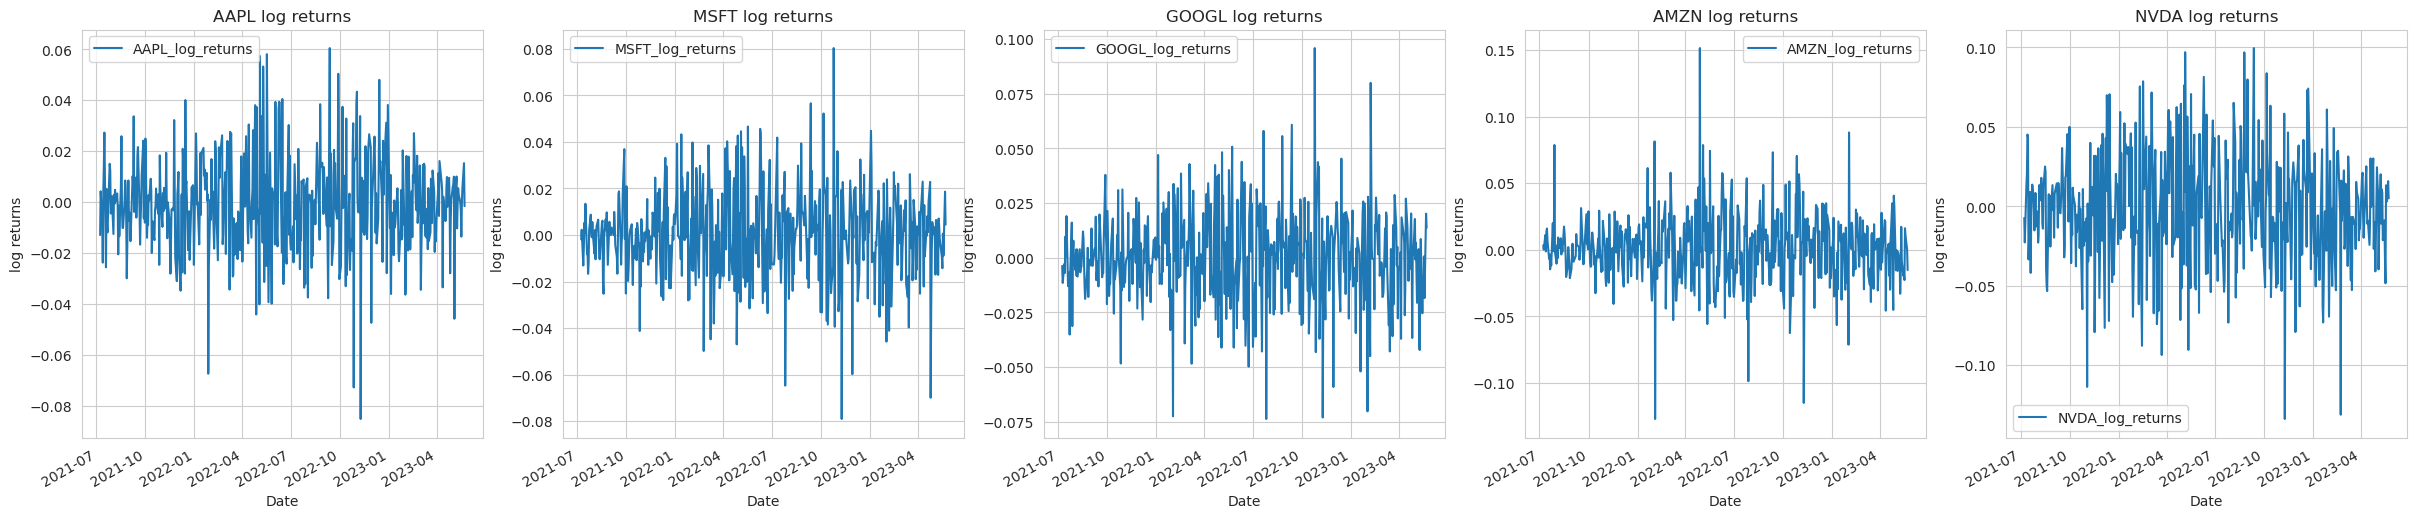

In [110]:
## let's look at some log_returns
fig, ax = plt.subplots(1,5, figsize=(30,6))

i=0
for col in tech_tickers:
    tech_data.plot(y=f'{col}_log_returns',
               ylabel='log returns',
               ax=ax[i],
               title=f"{col} log returns")
    i += 1


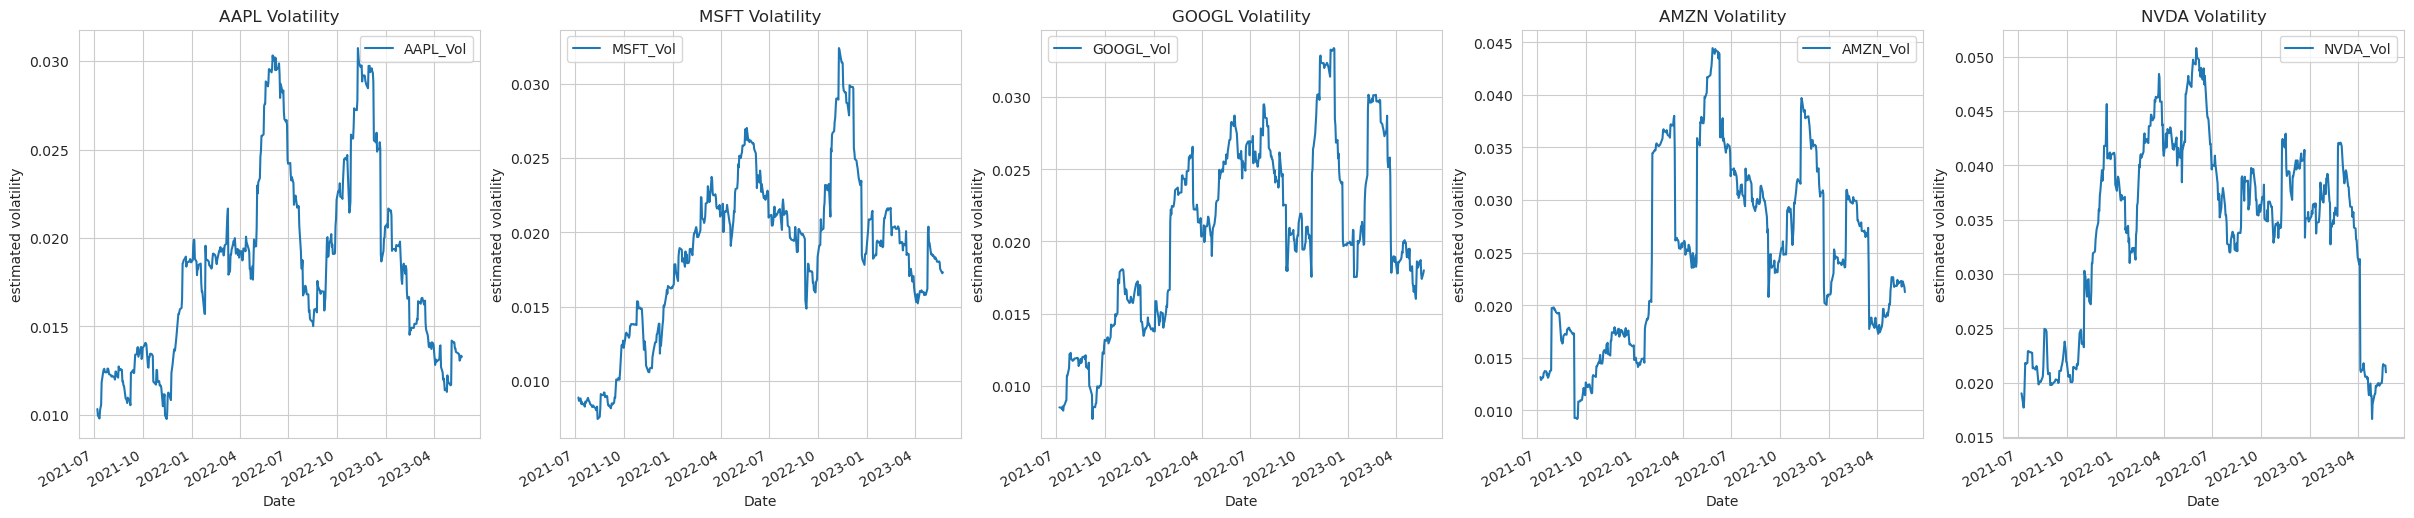

In [111]:
## let's look at some log_returns
fig, ax = plt.subplots(1,5, figsize=(30,6))

i=0
for col in tech_tickers:
    tech_data.plot(y=f'{col}_Vol',
               ylabel='estimated volatility',
               ax=ax[i],
               title=f"{col} Volatility")
    i += 1


Some key observations:
- The `log_returns` seem to be centered (i.e. have mean 0), which is a basic assumption of many variance models. 
- There are periods of relative calm variance with periods of variance clustered together. This variance clustering is also a sign that the standard variance models can be fit. 

***

## Exploratory Data Analysis

As we want to forecast volatility, we need to check that it is a stationary time series. 

### Checking for Stationarity

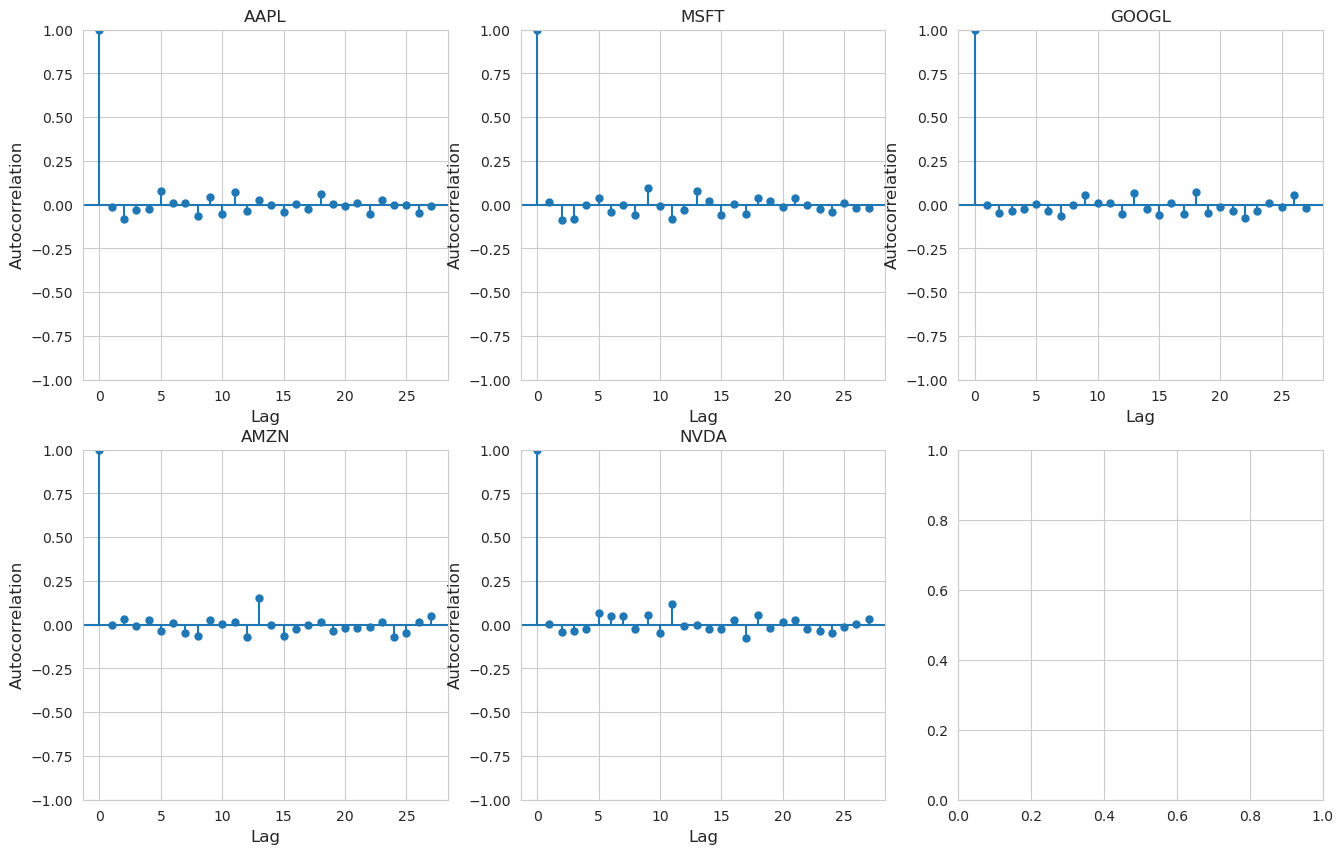

In [112]:
import statsmodels.api as sm

fig, ax = plt.subplots(2,3,figsize=(16,10))

j = 0
i = 0
for col in tech_tickers:
    sm.graphics.tsa.plot_acf(tech_data[f'{col}_log_returns'],
                                alpha = None,
                                ax=ax[i,j])

    ax[i,j].set_title(f'{col}', fontsize=12)
    ax[i,j].set_ylabel("Autocorrelation", fontsize=12)
    ax[i,j].set_xlabel("Lag", fontsize=12)

    j += 1

    if j == 3:
        j = 0
        i = 1

Looking at these plots, it seems like stationarity is satisfied by each of the tech stocks. But to double check, we will run a unit test, called the **Augmented Dickie-Fuller** test. 

In [113]:
from statsmodels.tsa.stattools import adfuller

for col in tech_tickers:
    print(f"p-value for {col} ADF Test is", adfuller(tech_data[f'{col}_log_returns'])[1])

p-value for AAPL ADF Test is 1.4824825753130102e-29
p-value for MSFT ADF Test is 1.79924828196537e-26
p-value for GOOGL ADF Test is 0.0
p-value for AMZN ADF Test is 0.0
p-value for NVDA ADF Test is 0.0


Since these p-values are all within a 5% confidence, we can reject the null hypothesis and conclude that our stocks are stationary. We can therefore fit ARMA models to the volatility, and no differencing is required. 

***
## Model Fittings

Here we implement the ARCH and GARCH for modelling the variance of the returns process $\mathbf{R}_t$. 

### ARCH

A **auto-regressive conditionally heteroscedastic** (ARCH) model is a model for the variance $\sigma_t^2$ of a time series in which the variance can be modelled using the past observations of the time series. For us, an $\text{ARCH}(m)$ model is: 

$$ 
\text{Var}(r_t | r_{t-1}, r_{t-2}, \dots, r_{t-m}) = \sigma_t^2 = \alpha_0 + \alpha_1 r_{t-1}^2 + \dots + \alpha_m r_{t-m}^2.
$$
The model essentially assumes that the squared returns process $\mathbf{R}_t^2$ follows a AR($m$) model. 

To decide if ARCH is a good model for our data, we can look at the AC plots for both $r_t$ and $r_t^2$: 

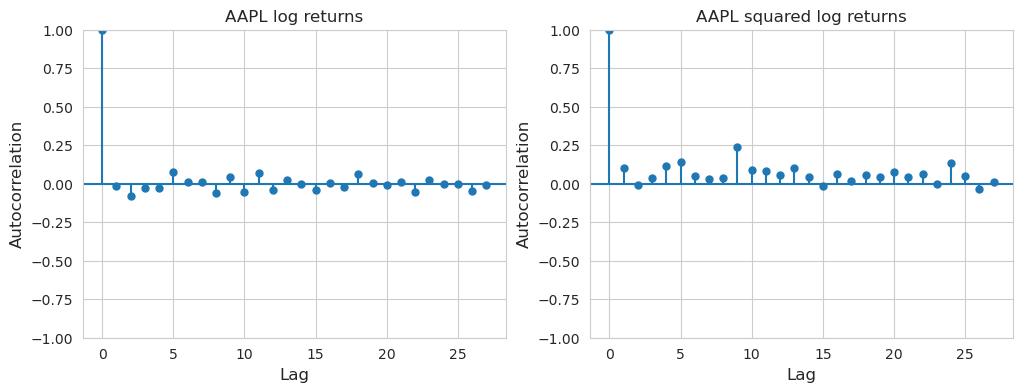

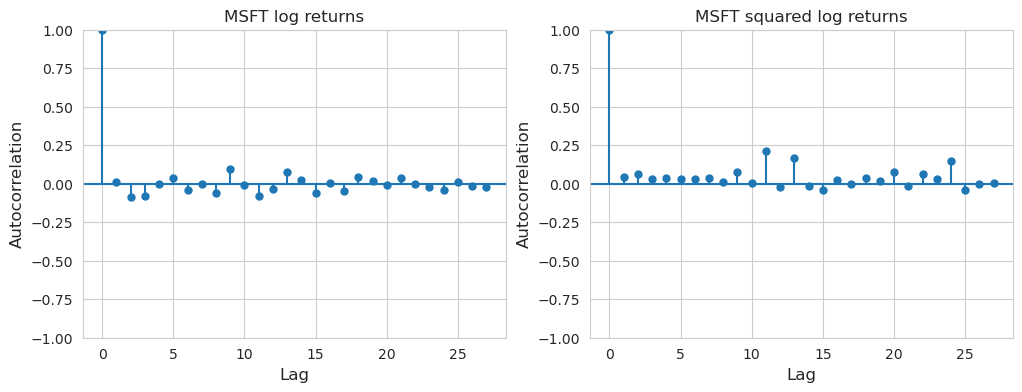

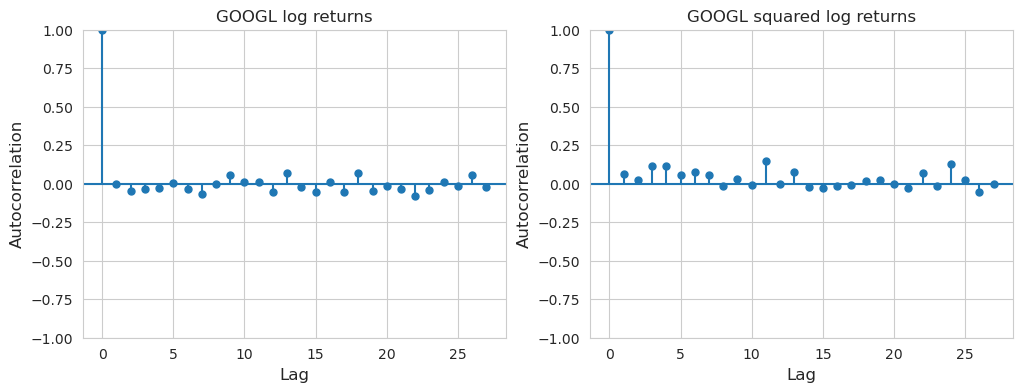

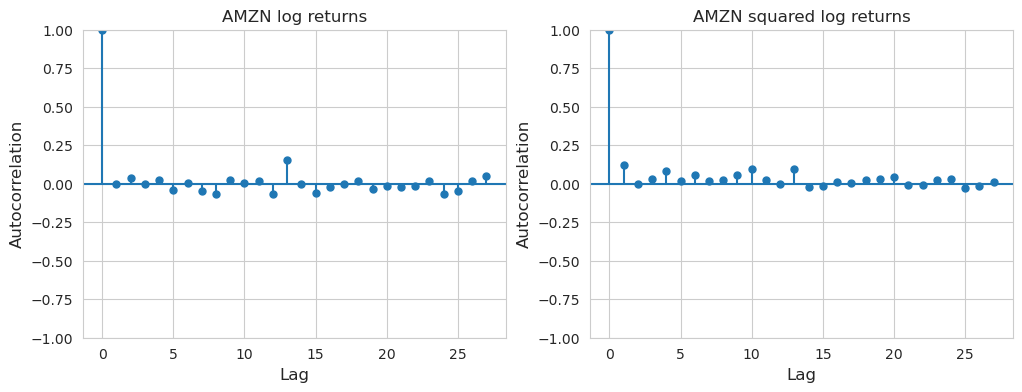

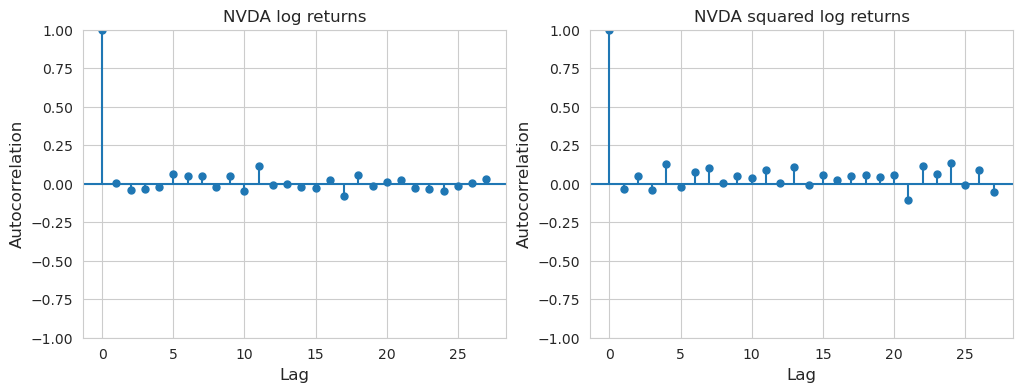

In [114]:
for col in tech_tickers:
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    ## log returns acf plot
    sm.graphics.tsa.plot_acf(tech_data[f'{col}_log_returns'],
                                alpha = None,
                                ax=ax[0])
    ax[0].set_title(f'{col} log returns', fontsize=12)
    ax[0].set_ylabel("Autocorrelation", fontsize=12)
    ax[0].set_xlabel("Lag", fontsize=12)

    ## squared log returns acf plot
    sm.graphics.tsa.plot_acf(np.square(tech_data[f'{col}_log_returns']),
                                alpha = None,
                                ax=ax[1])
    ax[1].set_title(f'{col} squared log returns', fontsize=12)
    ax[1].set_ylabel("Autocorrelation", fontsize=12)
    ax[1].set_xlabel("Lag", fontsize=12)
    

In each case, the `log_returns` process looks like white noise, but the squared-`log_process` looks like a AR(1) model. This is a sign that fitting a ARCH(1) may be appropriate. 

To fit a ARCH(1) model, we need the `arch` package. This can be installed using the following:

In [89]:
# ## if install using pip
# %pip install arch --upgrade --quiet

# ## if install using conda
# %conda install arch-py -c conda-forge

We now want the `arch_model` function. 

In [90]:
from arch import arch_model
from datetime import datetime, timedelta

In [120]:
## empty dictionary to hold the arch models 
arch_models = {}

## get the date that was five days ago
today = datetime.now().date()
thirty_days_ago = today - timedelta(days=30)

## for each stock, fit a ARCH(1) model
for col in tech_tickers:
    am = arch_model(tech_data[f'{col}_log_returns'],
                    vol='ARCH',
                    mean='Zero',
                    p=30,
                    rescale=False)
    ## fit to everything but the last 5 days
    res = am.fit(last_obs=str(thirty_days_ago))
    arch_models[f'{col}'] = res

Iteration:      1,   Func. Count:     33,   Neg. LLF: 1153.212768565144
Iteration:      2,   Func. Count:     66,   Neg. LLF: -809.4004186462357
Iteration:      3,   Func. Count:    101,   Neg. LLF: -507.1950422264306
Iteration:      4,   Func. Count:    134,   Neg. LLF: 952.7556566637169
Iteration:      5,   Func. Count:    167,   Neg. LLF: -1051.592312292725
Iteration:      6,   Func. Count:    200,   Neg. LLF: -1147.9435595195614
Iteration:      7,   Func. Count:    234,   Neg. LLF: -1028.0937015139507
Iteration:      8,   Func. Count:    267,   Neg. LLF: -483.8823396243177
Iteration:      9,   Func. Count:    300,   Neg. LLF: -1019.8395405906567
Iteration:     10,   Func. Count:    333,   Neg. LLF: -1119.682113239678
Iteration:     11,   Func. Count:    366,   Neg. LLF: -1142.2197708967806
Iteration:     12,   Func. Count:    399,   Neg. LLF: -1159.8033361947205
Iteration:     13,   Func. Count:    432,   Neg. LLF: -1135.5884284383806
Iteration:     14,   Func. Count:    465,   Neg

In [121]:
forecasts = {}

## generate 5-day forecasts for each stock
for col in tech_tickers:
    forecasts[f'{col}'] = arch_models[f'{col}'].forecast(reindex=False)

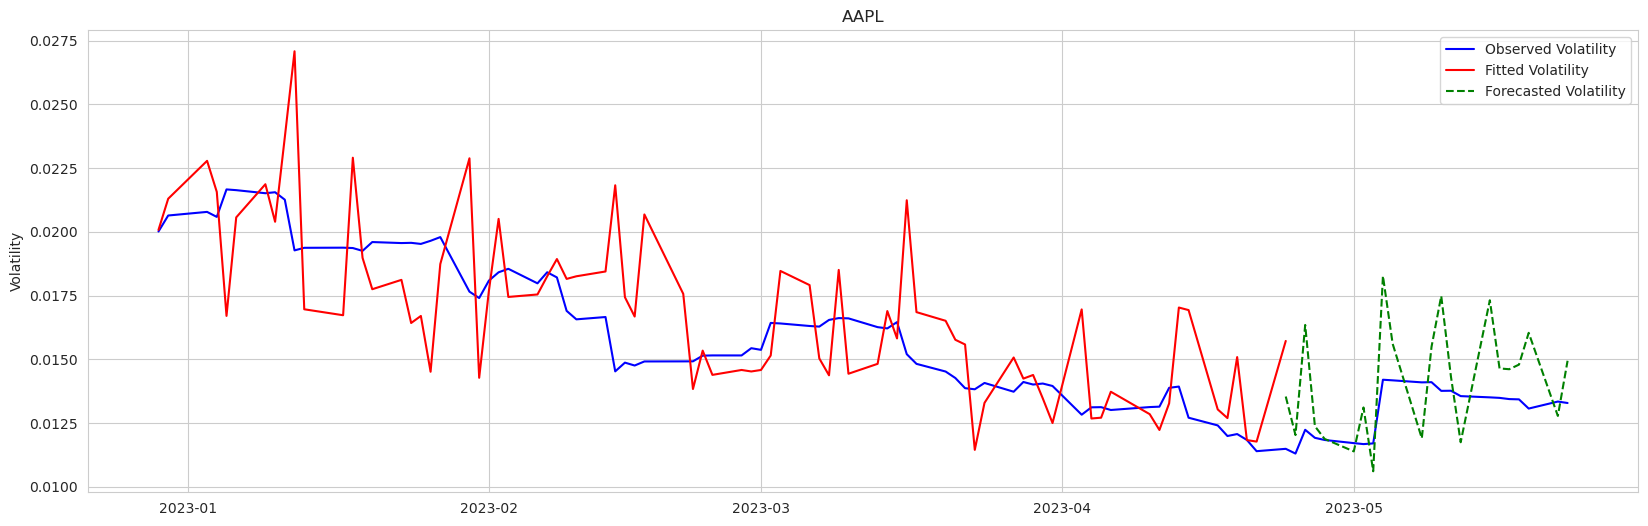

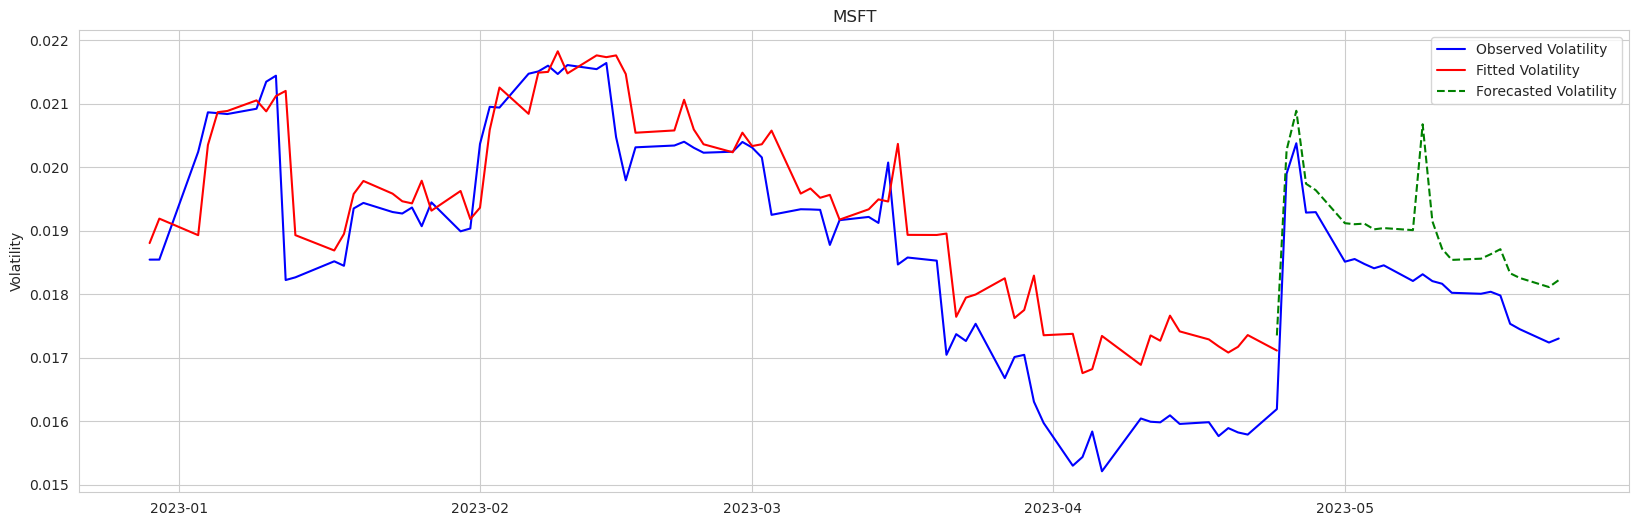

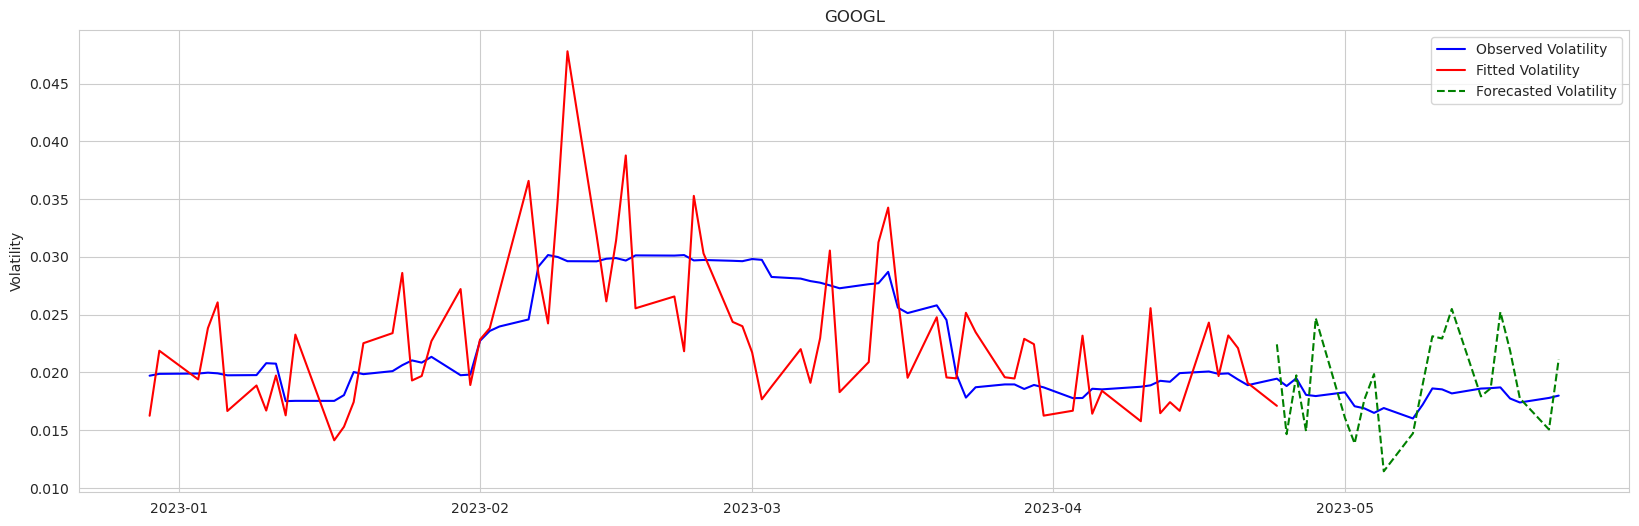

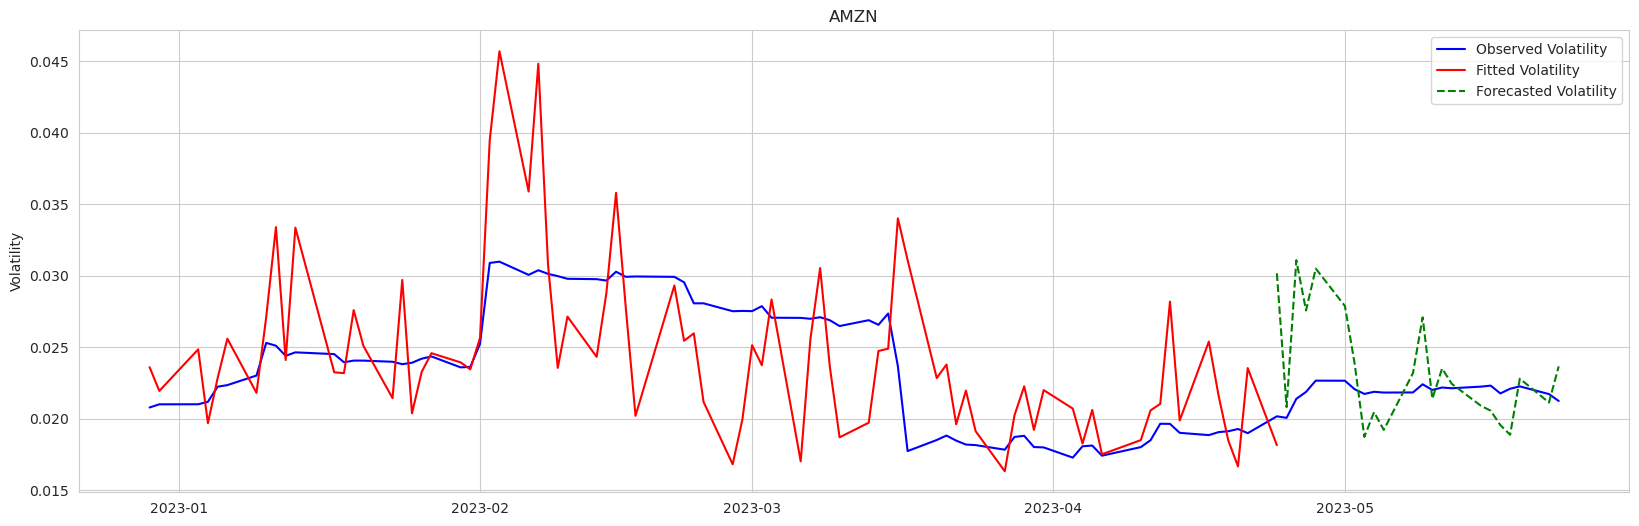

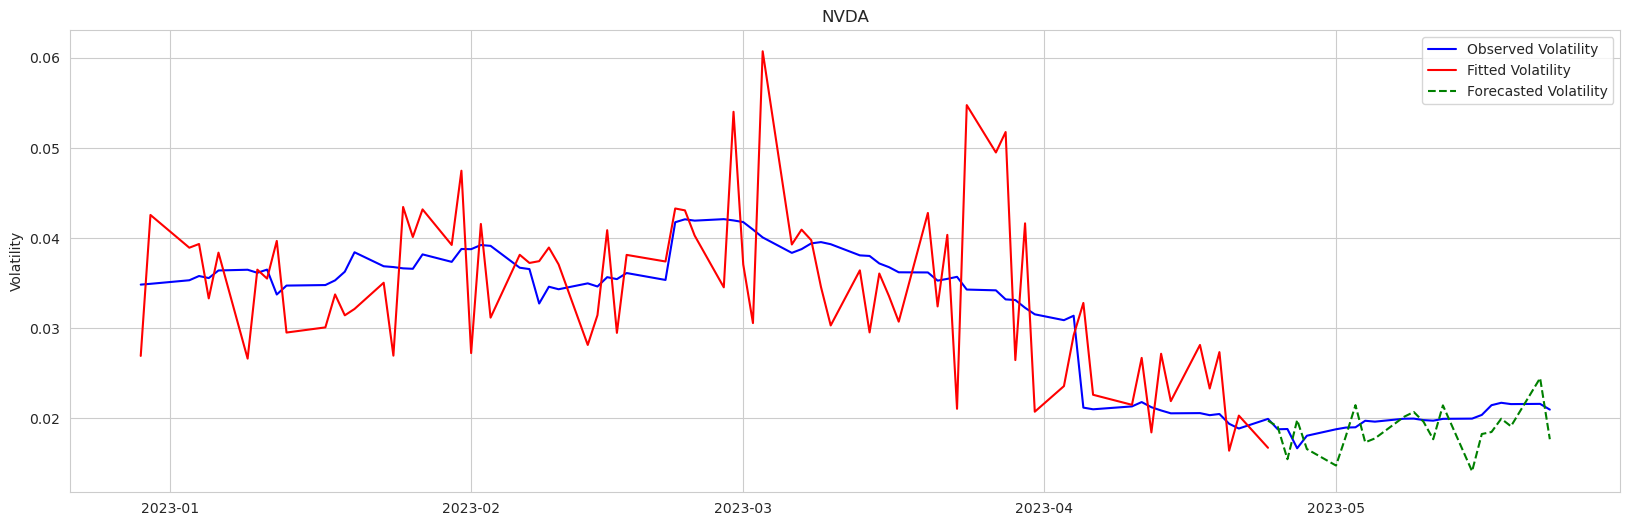

In [123]:
for col in tech_tickers:
    fig = plt.figure(figsize=(20,6))

    ## plot the observed data
    plt.plot(tech_data[f"{col}_Vol"][-100:],
                c='blue',
                label='Observed Volatility',
                ) 
    
    ## plot the fitted volatilities
    plt.plot(arch_models[f'{col}'].conditional_volatility[-100:],
             c='red',
             label='Fitted Volatility',
             )
    
    ## plot the forecasted volatilties
    plt.plot(np.sqrt(forecasts[f'{col}'].variance),
             c='green',
             label='Forecasted Volatility',
             linestyle='--'
             )
    
    plt.legend()
    plt.title(f"{col}")
    plt.ylabel("Volatility")
    

In [124]:
from sklearn.metrics import mean_squared_error

for col in tech_tickers:
    print(f"MSE for {col} forecast is", mean_squared_error(tech_data[f'{col}_Vol'][-len(forecasts[f'{col}'].variance):], 
                                                           forecasts[f'{col}'].variance)
         )

MSE for AAPL forecast is 0.00016354093759657435
MSE for MSFT forecast is 0.00032138822759418344
MSE for GOOGL forecast is 0.0003095186156464699
MSE for AMZN forecast is 0.0004535232513756194
MSE for NVDA forecast is 0.00037897285438999814
